In [1]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
import os

CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
}

files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}


### Release GPU

In [3]:
# RELEASE GPU BEING COMPLETELY CONSUMED, IF EXISTS

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: 
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RunTimeError as e:
        print(e)

### LOAD MODEL

In [5]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

NotFoundError: NewRandomAccessFile failed to Create/Open: Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config : The system cannot find the file specified.
; No such file or directory

### Image Detection

In [5]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [120]:
# IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test','Cars425.png')

IMAGE_PATH = "C:\\Users\\Asus vivobook\\Downloads\\kl1.jpg"

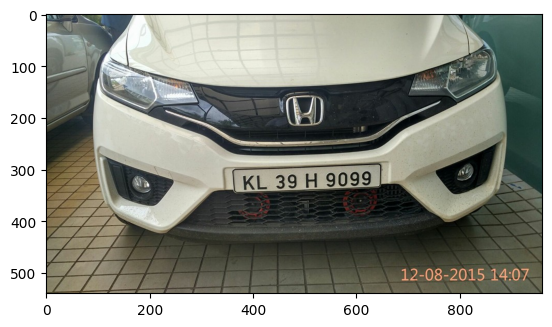

In [121]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

### APPLYING OCR TO IMAGE

In [122]:
print(detections)

{'detection_boxes': array([[0.5368176 , 0.36539572, 0.63535744, 0.6871858 ],
       [0.8977639 , 0.6701797 , 0.97692114, 1.        ],
       [0.7651006 , 0.08146332, 0.794718  , 0.1366041 ],
       [0.7763398 , 0.07873437, 0.8039898 , 0.13528693],
       [0.7595798 , 0.07694849, 0.7868563 , 0.12474562],
       [0.78313655, 0.08698567, 0.815406  , 0.13598815],
       [0.7657188 , 0.0707261 , 0.793033  , 0.11936453],
       [0.8578881 , 0.03801121, 0.8847376 , 0.10027225],
       [0.85590935, 0.02328062, 0.8826784 , 0.0644736 ],
       [0.6819798 , 0.03708816, 0.7129371 , 0.09120076],
       [0.76229596, 0.01263493, 0.7957628 , 0.04628326],
       [0.91259617, 0.7014556 , 0.96137756, 0.99992716],
       [0.7814503 , 0.01178854, 0.81570125, 0.04560267],
       [0.55523837, 0.39708748, 0.6260091 , 0.6592474 ],
       [0.50301623, 0.36097038, 0.6628307 , 0.6758814 ],
       [0.8599613 , 0.05288113, 0.8856628 , 0.11748765],
       [0.86936706, 0.03596581, 0.8953034 , 0.09428642],
       [0.7

In [123]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

In [124]:
import easyocr

In [125]:
detection_threshold = 0.5       # only if this threshold is matched, we'll fetch data 

In [126]:
image = image_np_with_detections

scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))     # filtering suitable scores

# box coordinates and keys
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

print(detections['detection_scores'])           # confidence matrix
# we need to iterate through these scores and only get the once above threshold

print(scores)           # the above threshold values

[0.67404836 0.20347276 0.11465313 0.1133835  0.11226017 0.1118565
 0.10843132 0.10768151 0.10642031 0.10428185 0.10357703 0.10236945
 0.10128983 0.09628146 0.09610495 0.09331966 0.0893218  0.08833604
 0.0875823  0.08344988 0.08179463 0.08177242 0.07997726 0.07926843
 0.07829661 0.07581721 0.07578606 0.07542447 0.07451603 0.07443164
 0.07373114 0.07371746 0.07365984 0.07338537 0.07306197 0.07208857
 0.07151544 0.07135016 0.07092852 0.0708409  0.07080729 0.07047484
 0.06919155 0.06866579 0.06831905 0.06822172 0.06788132 0.06685352
 0.06612312 0.06535988 0.06446001 0.06431238 0.06418638 0.06407867
 0.06397686 0.06382517 0.0628746  0.06208943 0.06193692 0.05982926
 0.05977302 0.05907705 0.05876488 0.05829719 0.05808135 0.05793776
 0.05718403 0.05620128 0.05609479 0.05600551 0.05566134 0.05545721
 0.05528358 0.05485768 0.05441279 0.05404179 0.05383699 0.0537428
 0.0536423  0.0534511  0.05262459 0.05217248 0.05190809 0.0517894
 0.05065671 0.05054053 0.05053243 0.04976692 0.0490825  0.0490326

In [127]:
width = image.shape[1]
height = image.shape[0]

print(width, "\t", height)

960 	 540


[([[28, 7], [286, 7], [286, 54], [28, 54]], 'KL 39 H 9099', 0.878724602495911)]


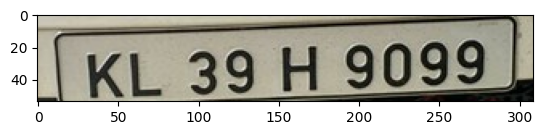

In [128]:
# LOOPING THROUGH ALL THE DATA IN BOXES (region of interest ----------> ROI)

for idx, box in enumerate(boxes):

    # getting region of interest
    # print(box)
    roi = box*[height, width, height, width]
    # print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)                #----------> TEXT
    print(ocr_result)

    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [129]:
for result in ocr_result:
    print(np.sum(np.subtract(result[0][2],result[0][1])))
    print(result[1])

47
KL 39 H 9099


### FILTERING (optional)

In [130]:
region_threshold = 0.05

def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate = [] 
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
    return plate

filter_text(region, ocr_result, region_threshold)

['KL 39 H 9099']

### MAIN FUNCTION TO BE EXECUTED

In [131]:
region_threshold = 0.6

def ocr_it(image, detections, detection_threshold, region_threshold):
    
    # Scores, boxes and classes above threhold
    scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        
        text = filter_text(region, ocr_result, region_threshold)
        
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        plt.show()
        print(text)
        return text, region

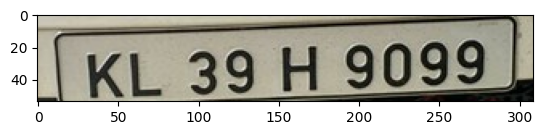

['KL 39 H 9099']


In [132]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

In [ ]:
from PIL import Image

data = Image.fromarray(region)

import io
buffer = io.BytesIO()

x = data.save(buffer, format='PNG')
plt.imshow(buffer.getvalue())


<hr><hr>

# <center> LIVE TESTING</center>

### USING WEBCAM

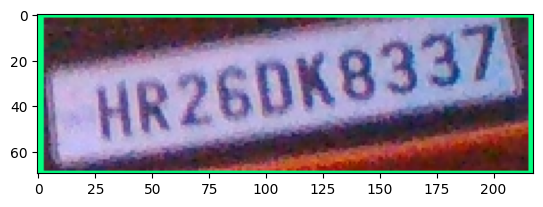

[]


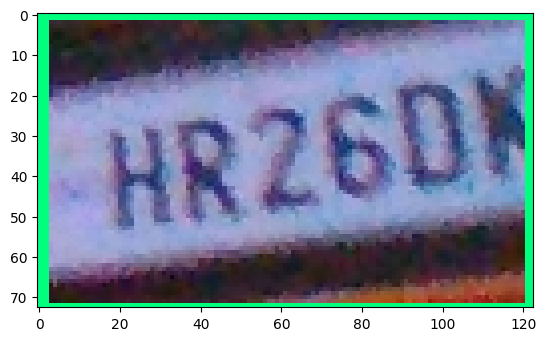

[]


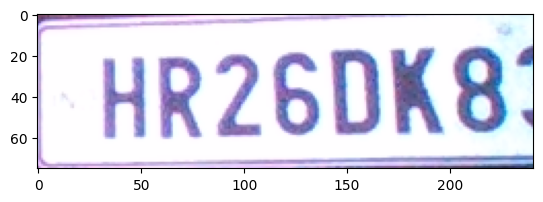

['HRZSDK8']


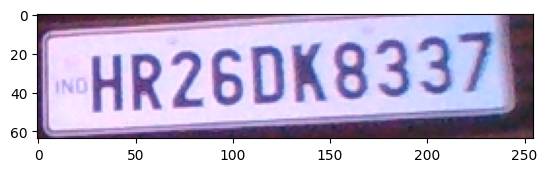

['HRZGDK8337']


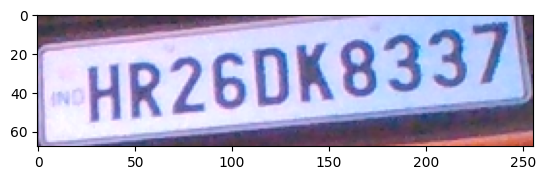

['HR26DK8337']


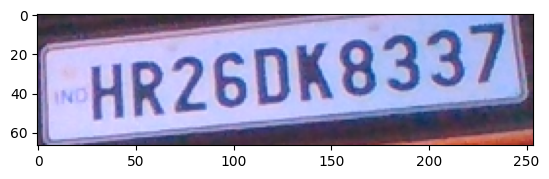

['HR26DK8337']


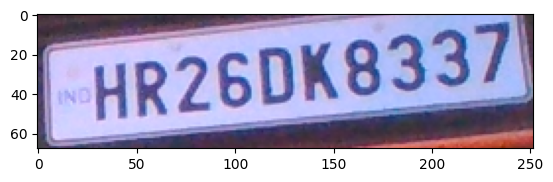

['HRZSDK8337]']


In [48]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

<hr><hr>